# Object Detection Pipeline - Hyperparameter Tuning & Model Training
This notebook demonstrates the complete pipeline for training different YOLO models on aerial imagery. Besides, Hyperparameter tuning with Ray Tune on validation set, followed by final training on train+val and evaluation on test set.

Github Repo and Documentation of the work : [DL4CV Coconut Detection](https://github.com/kshitijrajsharma/dl4cv-oda)

By/ Kshitij Raj Sharma, Sahar Mohamed



[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kshitijrajsharma/dl4cv-oda/blob/master/notebooks/train.ipynb)

This dl4cv_oda package includes all the pipline steps and functions for coconut trees, more info in the repo here: [DL4CV Coconut Detection](https://github.com/kshitijrajsharma/dl4cv-oda)

In [ ]:
# !pip install dl4cv_oda

# Overview for the models

## YOLOv8 – Architecture Summary

**YOLOv8** is the latest state-of-the-art real-time object detection model in the YOLO family developed by Ultralytics. It improves on previous versions with a modern and efficient design that enhances speed and accuracy.

### Core Components
- **Backbone:** A convolutional neural network (CNN) that extracts hierarchical features from input images.
- **Neck:** Combines multi-scale features to help detect objects of different sizes; uses modules like FPN/PAN variants.
- **Head:** A prediction module that outputs object bounding boxes and class scores in one forward pass.

### Key Improvements
- **Anchor-free detection:** Predicts object centers directly instead of relying on predefined anchor boxes.
- **C2f modules:** An enhanced feature block that replaces older C3 blocks, improving feature extraction efficiency. :contentReference[oaicite:5]{index=5}  
- **Split head design:** Decouples classification and regression for better optimization and accuracy.  
- **Multi-task support:** Works for detection, segmentation, classification, and pose estimation within a unified API.

YOLOv8 excels at balancing high speed and competitive accuracy**, especially for real-time applications and custom datasets.

-------------------------------------------------------------------
## **YOLOv12 – Architecture Summary**

**YOLOv12** is the newest evolution of the YOLO family, introducing **attention mechanisms** into the YOLO framework to improve performance while maintaining real-time speeds.

### What’s New
YOLOv12 combines the rapid inference of CNN-based detectors with the **enhanced modeling power of attention**, achieving both speed and accuracy improvements.

### Core Innovations
- **Area Attention Module:** Efficient attention mechanism that scales well with high-resolution feature maps, enhancing context awareness.
- **Residual Efficient Layer Aggregation Networks (R-ELAN):** A powerful backbone that improves feature extraction efficiency and gradient flow.
- **Architectural Enhancements:** Optimized connectivities and attention-friendly layers to balance compute cost and detection performance.

### Advantages
- **Better context modeling** than pure CNNs  
- Stronger performance on small and detailed objects  
- Competitive speed performance due to attention-centric design

YOLOv12 sets a new benchmark for real-time object detection by merging attention mechanisms with efficient architecture, pushing performance beyond earlier YOLO versions.

Source: Ultralytics

-------------------------------------------------------------------

## **RT-DETR (Real-Time Detection Transformer)**
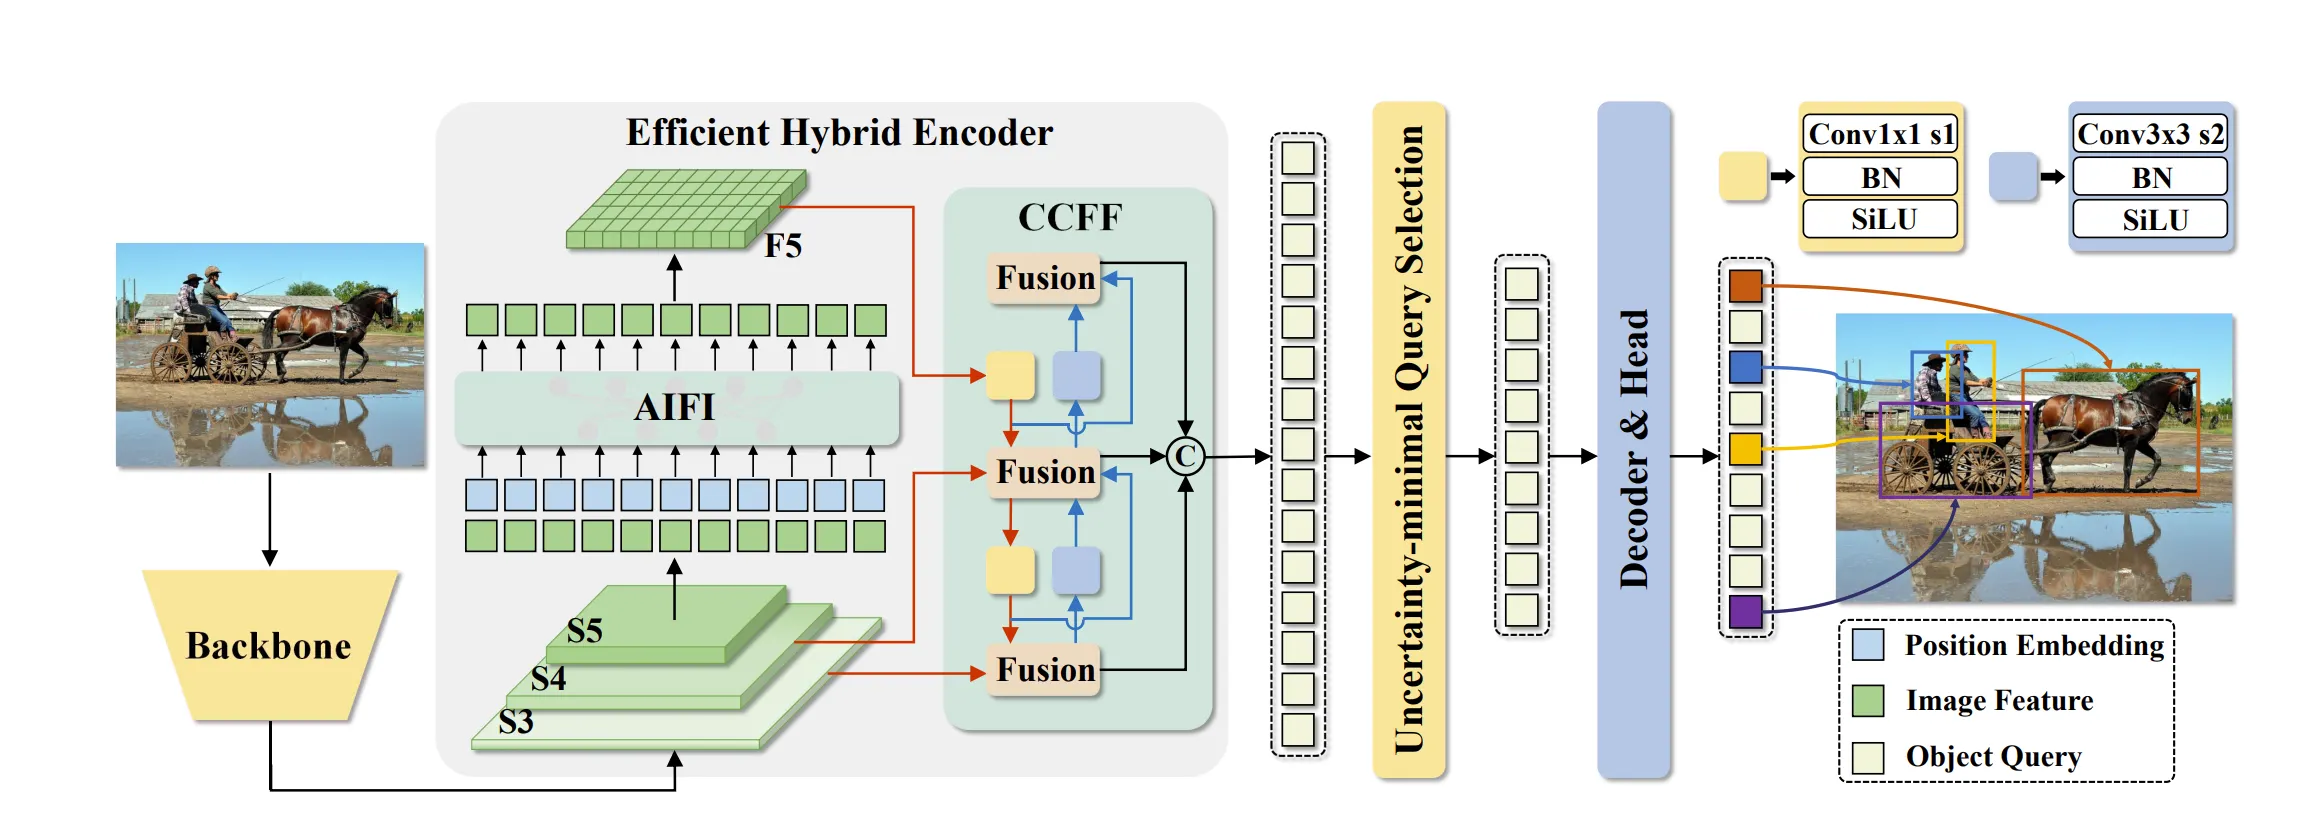

RT-DETR is the first **real-time, end-to-end object detector** based on Transformers. Unlike YOLO-style detectors, it **removes Non-Maximum Suppression (NMS)** and directly predicts a fixed set of objects in one forward pass.

### Key Ideas
- **Hybrid Encoder:** Efficient multi-scale feature fusion with lower computational cost than standard Transformers.
- **Uncertainty-Minimal Query Selection:** Selects high-confidence features to initialize object queries, improving localization and detection of small or dense objects.
- **End-to-End Detection:** No anchors and no NMS, leading to simpler and more stable inference.

### Highlights
- Strong performance in crowded scenes
- Better global context modeling than CNN-only detectors
- Real-time capable on GPUs (slower on CPU/MPS)

RT-DETR bridges the gap between DETR accuracy and YOLO speed by combining efficient Transformer design with end-to-end detection.




## Step 1 : Data Preprocessing

In [ ]:
import requests
import geopandas as gpd
from pathlib import Path
from dl4cv_oda import (clean_osm_data, clip_labels_to_tiles, convert_to_yolo_format,
                       create_train_val_split, create_yolo_config, download_tiles)

In [ ]:
DATA_DIR = Path("../data")
RAW_DIR = DATA_DIR / "raw"
CHIPS_DIR = DATA_DIR / "chips"
LABELS_DIR = DATA_DIR / "labels"
YOLO_DIR = DATA_DIR / "yolo"

OSM_FILE = RAW_DIR / "kolovai-trees.geojson"
CLEANED_FILE = RAW_DIR / "cleaned.geojson"
TREES_BOX_FILE = DATA_DIR / "trees_box.geojson"
TILES_FILE = DATA_DIR / "tiles.geojson"

if not OSM_FILE.exists():
    OSM_FILE.parent.mkdir(parents=True, exist_ok=True)
    OSM_FILE.write_bytes(requests.get("https://github.com/kshitijrajsharma/dl4cv-oda/blob/master/data/raw/kolovai-trees.geojson?raw=true", allow_redirects=True).content)
    print(f"Downloaded OSM data")

if not CLEANED_FILE.exists():
    count = clean_osm_data(str(OSM_FILE), str(CLEANED_FILE), str(TREES_BOX_FILE))
    print(f"Cleaned {count} trees")

if not TILES_FILE.exists():
    data = gpd.read_file(TREES_BOX_FILE)
    data.to_crs(epsg=4326, inplace=True)
    bbox = list(data.total_bounds)
    await download_tiles(bbox, 19, "https://tiles.openaerialmap.org/5a28639331eff4000c380690/0/5b1b6fb2-5024-4681-a175-9b667174f48c/{z}/{x}/{y}.png", DATA_DIR, 'OAM')
    print("Downloaded tiles")

#### Step 1.1 Train - Val Split and Configuration

In [ ]:
if not (YOLO_DIR / "train").exists():
    stats = clip_labels_to_tiles(str(TREES_BOX_FILE), str(TILES_FILE), str(LABELS_DIR))
    print(f"Clipped {stats['total_trees']} trees to {stats['processed']} tiles")
    
    class_mapping = convert_to_yolo_format(str(TREES_BOX_FILE), str(CHIPS_DIR), str(LABELS_DIR), str(YOLO_DIR), target_species="Coconut")
    print(f"Converted to YOLO format")
    
    train_count, val_count, test_count = create_train_val_split(str(LABELS_DIR), str(CHIPS_DIR), str(YOLO_DIR), train_ratio=0.7, val_ratio=0.2, test_ratio=0.1, seed=42)
    print(f"Split: train={train_count}, val={val_count}, test={test_count}")
    
    config_file = create_yolo_config(str(YOLO_DIR), {"Coconut": 0})
    print(f"Config: {config_file}")

print("Data preparation complete")

## Runtime configuration

In [ ]:
IMG_SIZE = 256
EPOCHS = 200
PATIENCE = 10
BATCH_SIZE = 16

MODELS_TO_TRAIN = {
    "yolov8l": "yolov8l.pt",
    "yolo12l": "yolo12l.pt",
    "rtdetr-l": "rtdetr-l.pt"
}

## Step 2 : Hyper Parameter Tuning 

## Step 3 : Model Training 

## Step 4 : Model Evaluation on test set